In [ ]:
## 1. Importing Libraries

In [91]:
import pandas as pd

import numpy as np

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt

In [2]:
## 2. Display Settigs

In [3]:
pd.set_option("display.max_columns",None)

In [4]:
sklearn.set_config(transform_output="pandas")

In [5]:
## 3. Getting the data

In [6]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
val_df = pd.read_csv("data/val.csv")

In [7]:
train_df

,Have_IP,Have_At,URL_Length,URL_Depth,Prefix/Suffix,Web_Traffic,iFrame,Mouse_Over,Web_Forwards,Label
0,0,0,0,0,1,0,0,0,0,1
1,0,0,1,3,0,0,0,0,0,0
2,0,0,1,1,0,1,1,1,1,1
3,0,0,1,9,0,1,0,0,0,0
4,0,0,1,10,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
523,0,0,1,3,0,1,1,1,1,0
524,0,0,1,1,0,1,0,0,0,1
525,0,0,1,0,1,0,0,0,0,1
526,0,1,1,2,1,0,0,0,0,1


In [8]:
## 3.1 Split the data

In [9]:
def split_data(data):
    X = data.drop(columns = "Label")
    y = data.Label.copy()
    return (X,y)

In [10]:
X_train, y_train = split_data(train_df)
X_test, y_test = split_data(test_df)
X_val, y_val = split_data(val_df)

In [11]:
X_train

,Have_IP,Have_At,URL_Length,URL_Depth,Prefix/Suffix,Web_Traffic,iFrame,Mouse_Over,Web_Forwards
0,0,0,0,0,1,0,0,0,0
1,0,0,1,3,0,0,0,0,0
2,0,0,1,1,0,1,1,1,1
3,0,0,1,9,0,1,0,0,0
4,0,0,1,10,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
523,0,0,1,3,0,1,1,1,1
524,0,0,1,1,0,1,0,0,0
525,0,0,1,0,1,0,0,0,0
526,0,1,1,2,1,0,0,0,0


In [12]:
y_train

0      1
1      0
2      1
3      0
4      1
      ..
523    0
524    1
525    1
526    1
527    0
Name: Label, Length: 528, dtype: int64

In [13]:
## 3.2 Meta-info

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Have_IP        528 non-null    int64
 1   Have_At        528 non-null    int64
 2   URL_Length     528 non-null    int64
 3   URL_Depth      528 non-null    int64
 4   Prefix/Suffix  528 non-null    int64
 5   Web_Traffic    528 non-null    int64
 6   iFrame         528 non-null    int64
 7   Mouse_Over     528 non-null    int64
 8   Web_Forwards   528 non-null    int64
dtypes: int64(9)
memory usage: 37.3 KB


In [15]:
## 4. Data Preprocessing

In [35]:
date_cols = [] #date
time_cols = [] #time
num_cols = [col for col in X_train.columns] #numeric
cat_cols = [] #categorical

In [105]:
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])
date_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week","day_of_month"], format="mixed")),
    ("scaler",StandardScaler())
])
time_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute", "second"], format="mixed")),
    ("scaler",StandardScaler())
])

In [37]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
    ("date", date_pipe, date_cols),
    ("time", time_pipe, time_cols)
])

In [38]:
X_train #before

,Have_IP,Have_At,URL_Length,URL_Depth,Prefix/Suffix,Web_Traffic,iFrame,Mouse_Over,Web_Forwards
0,0,0,0,0,1,0,0,0,0
1,0,0,1,3,0,0,0,0,0
2,0,0,1,1,0,1,1,1,1
3,0,0,1,9,0,1,0,0,0
4,0,0,1,10,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
523,0,0,1,3,0,1,1,1,1
524,0,0,1,1,0,1,0,0,0
525,0,0,1,0,1,0,0,0,0
526,0,1,1,2,1,0,0,0,0


In [39]:
preprocessor.fit_transform(X_train) #after

,num__Have_IP,num__Have_At,num__URL_Length,num__URL_Depth,num__Prefix/Suffix,num__Web_Traffic,num__iFrame,num__Mouse_Over,num__Web_Forwards
0,-0.165037,-0.351289,-1.509802,-1.217158,1.805011,-1.537224,-0.586098,-0.477396,-0.612372
1,-0.165037,-0.351289,0.662338,-0.183944,-0.554013,-1.537224,-0.586098,-0.477396,-0.612372
2,-0.165037,-0.351289,0.662338,-0.872753,-0.554013,0.650523,1.706198,2.094697,1.632993
3,-0.165037,-0.351289,0.662338,1.882486,-0.554013,0.650523,-0.586098,-0.477396,-0.612372
4,-0.165037,-0.351289,0.662338,2.226891,-0.554013,0.650523,-0.586098,2.094697,-0.612372
...,...,...,...,...,...,...,...,...,...
523,-0.165037,-0.351289,0.662338,-0.183944,-0.554013,0.650523,1.706198,2.094697,1.632993
524,-0.165037,-0.351289,0.662338,-0.872753,-0.554013,0.650523,-0.586098,-0.477396,-0.612372
525,-0.165037,-0.351289,0.662338,-1.217158,1.805011,-1.537224,-0.586098,-0.477396,-0.612372
526,-0.165037,2.846656,0.662338,-0.528348,1.805011,-1.537224,-0.586098,-0.477396,-0.612372


In [41]:
## 5. Model Selection

In [44]:
algorithms = {
    "Linear Regression" : LinearRegression(),
    "Support Vector Machine" : SVR(),
    "Random Forest" : RandomForestRegressor(n_estimators=10),
    "XG Boost" : XGBRegressor(n_estimators=10)
}

In [54]:
data = pd.concat([train_df, val_df], axis = 0)
X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(704, 9) (704,)


In [72]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )
    ax.fill_between(
        x=sizes,
        y1=mean_scores-std_scores,
        y2=mean_scores+std_scores,
        alpha=0.5
    )

In [75]:
def plot_learning_curves(name, algorithm, figsize=(12,4)):
    model = Pipeline(steps=[
        ("pre",preprocessor),
        ("alg",algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    #training curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train({train_score})",
        ax
    )

    #testing curve
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R-square", title =name)

    ax.legend(loc="lower right")

    plt.show()

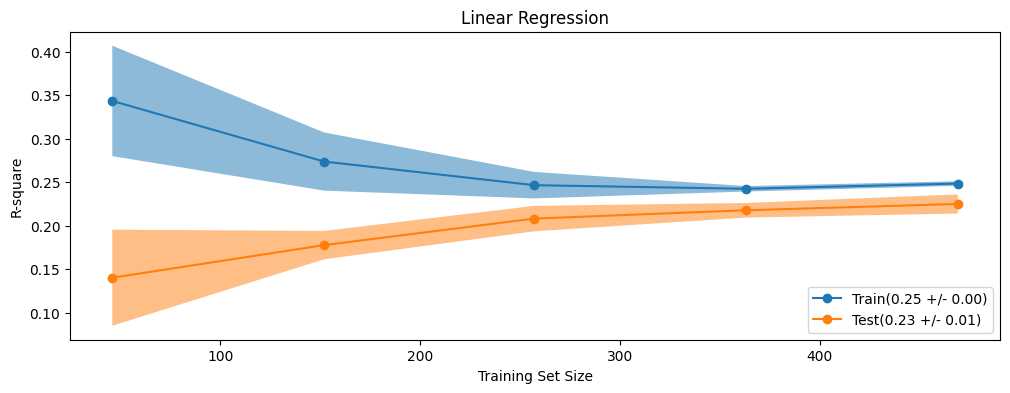

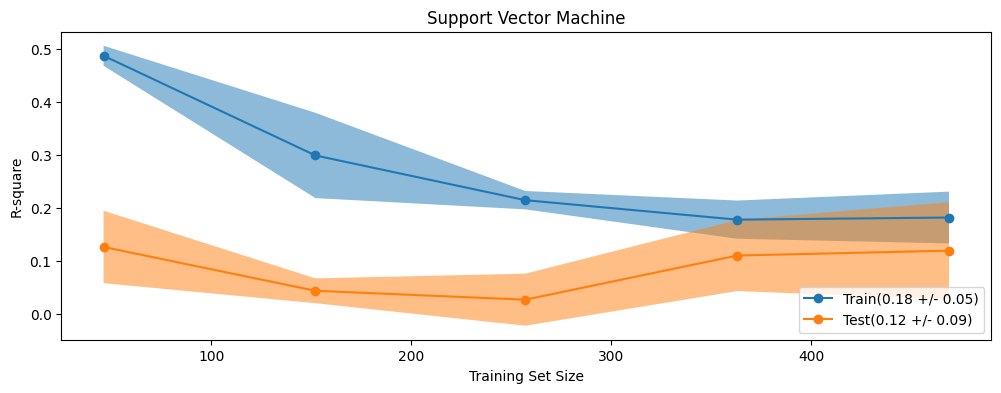

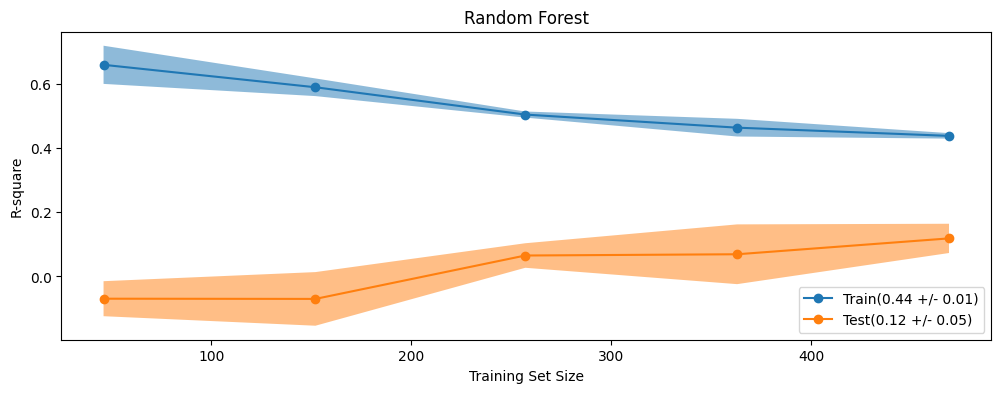

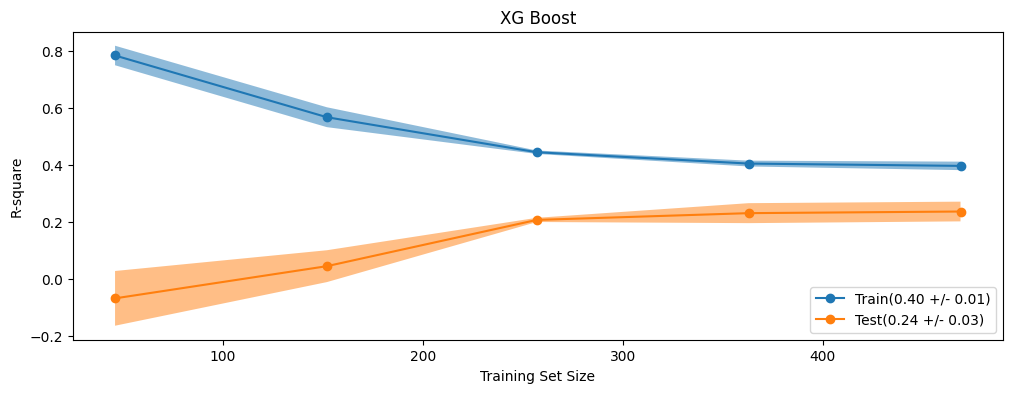

In [76]:
for name, alg in algorithms.items():
    plot_learning_curves(name, alg)

In [78]:
## 6. Model Training

In [79]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=10))
])

In [80]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Have_IP', 'Have_At',
                                                   'URL_Length', 'URL_Depth',
                                                   'Prefix/Suffix',
                                                   'Web_Traffic', 'iFrame',
                                                   'Mouse_Over',
                                                   'Web_Forwards']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encod...
                                                                   DatetimeFeatures(features_to_extract=['month',
                                                                                                         'week',
                                                                                                         'day_of_week',
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute',
                                                                                                         'second'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [81]:
## 7. Model Evaluation

In [94]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [98]:
print(f"R2 score on training data is = {evaluate_model(X_data, y_data)}")

R2 score on training data is = 0.40031016122427854


In [99]:
print(f"R2 score on test data is = {evaluate_model(X_test, y_test)}")

R2 score on test data is = 0.07775571905626555


In [100]:
## 8. Model Persistence

In [101]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [103]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Have_IP', 'Have_At',
                                                   'URL_Length', 'URL_Depth',
                                                   'Prefix/Suffix',
                                                   'Web_Traffic', 'iFrame',
                                                   'Mouse_Over',
                                                   'Web_Forwards']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encod...
                                                                   DatetimeFeatures(features_to_extract=['month',
                                                                                                         'week',
                                                                                                         'day_of_week',
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute',
                                                                                                         'second'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [104]:
y_pred = saved_model.predict(X_test)
r2_score(y_test, y_pred)

0.07775571905626555